In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
from BRmodel import BRModel
# import required packages
import os
import scipy.io as sio
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
from pymcmcstat import mcmcplot as mcp
import pymcmcstat
print(pymcmcstat.__version__)
np.seterr(over='ignore');

1.9.1


In [99]:
data = pd.read_csv('prepared_wave.csv')
data['0-14'] = data['A(H1N1)pdm09_0-14'] + data['A(H3N2)_0-14'] + data['B_0-14']
data['15 и ст.'] = data['A(H1N1)pdm09_15 и ст.'] + data['A(H3N2)_15 и ст.'] + data['B_15 и ст.']
data['CONFIRMED'] = data['0-14'] + data['15 и ст.']
data['RECOVERED'] = 0

In [100]:
print(data.shape)
data.head()

(22, 22)


,Unnamed: 0,index,Год,Неделя,A(H1N1)pdm09_15 и ст.,A(H3N2)_15 и ст.,B_15 и ст.,Население 15 и ст.,A(H1N1)pdm09_15 и ст._rel,A(H3N2)_15 и ст._rel,...,A(H1N1)pdm09_0-14_rel,Население 0-14,A(H3N2)_0-14,A(H3N2)_0-14_rel,B_0-14,B_0-14_rel,0-14,15 и ст.,CONFIRMED,RECOVERED
0,NaN,156,2013,1,0,0,0,4374156,0.000000,0.000000,...,0.000000,579063,0,0.000000,0,0.000000,0,0,0,0
1,NaN,157,2013,2,318,159,318,4374156,0.072700,0.036350,...,2.355146,579063,192,1.176072,385,2.355146,962,795,1757,0
2,NaN,158,2013,3,1465,1046,0,4374156,0.334922,0.239132,...,9.505731,579063,1163,6.792017,0,0.000000,2791,2511,5302,0
3,NaN,159,2013,4,2181,727,242,4374156,0.498610,0.166203,...,14.933692,579063,865,4.981166,288,1.658063,3747,3150,6897,0
4,NaN,160,2013,5,4715,1275,687,4374156,1.077922,0.291485,...,34.003563,579063,1620,9.198878,873,4.956979,8481,6677,15158,0


In [104]:
# because shapes don't match??
data.loc[len(data), data.columns] = np.zeros(data.shape[1])
data.shape

(23, 22)

In [105]:
data['RECOVERED'][8:].shape, data['CONFIRMED'][:15].shape

((15,), (15,))

In [107]:
data['RECOVERED'][8:] = data['CONFIRMED'][:15]
data['ACTIVE'] = 0
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(23):
    if i < 7:
        data['ACTIVE'][i] = sum(data['CONFIRMED'][:i+1])
    else:
        data['ACTIVE'][i] = sum(data['CONFIRMED'][i-6:i+1])
        
data['DEATHS'] = 0
del data['Unnamed: 0']
del data['index']

<AxesSubplot:>

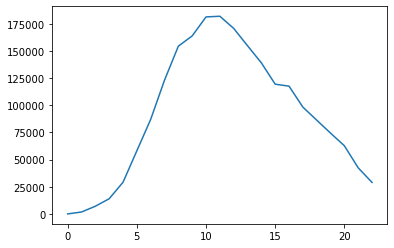

In [118]:
data['ACTIVE'].plot()

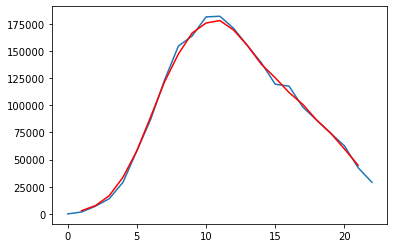

In [119]:
rolling = data['ACTIVE'].rolling(window=3, center = True)
rolling_mean = rolling.mean()
# print(rolling_mean.head(10))
# plot original and transformed dataset
data['ACTIVE'].plot()
rolling_mean.plot(color='red')
plt.show()

In [120]:
active = data['ACTIVE']

In [121]:
def phases(data_active):
    sh = 10
    i = sh
    phases_begin_day = [0]
    while i< len(data_active):
        up_array = np.array([data_active[i]<j for j in data_active[i-sh:i]]).mean()
        lo_array = np.array([data_active[i]<j for j in data_active[i:i+sh]]).mean()
    #     print(up_array)
        if (up_array > 0.75) and (lo_array >0.75):
            phases_begin_day.append(i)
            i+=sh
        else:
            i+=1      
    return phases_begin_day
phases(active)

[0]

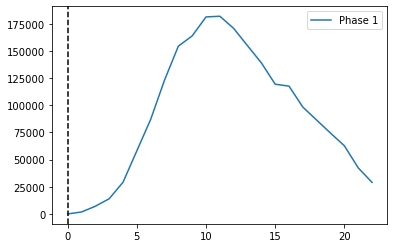

In [122]:
for i in range(len(phases(active))):
    try:
        active[phases(active)[i]:phases(active)[i+1]+1].plot(label = f'Phase {i+1}')
        plt.axvline(x=phases(active)[i],color='k', linestyle='--')

    except:
        active[phases(active)[i]:].plot(label = f'Phase {i+1}')
        plt.axvline(x=phases(active)[i], color='k', linestyle='--')
    plt.legend()

In [123]:
init_inf = data[['CONFIRMED', 'ACTIVE', 'RECOVERED' ]].values[:,0]
ma = 8
init_inf[ma-8:ma+15]
y = init_inf

In [124]:
def model_resid(args):
    mu, alpha, beta, I0 = args
    pop = 4581854.0
    I0 /= pop
    m = BRModel([[6.528]], pop, mu, 'total', '', '')
    exposed_list, lam_list, a = [I0], [beta], [alpha]
    m.set_attributes()
    m.init_simul_params(exposed_list, lam_list, a)
    m.set_attributes()

    Y, population_immunity, rho, r0, rt = m.make_simulation()
    Y = Y[0][0]
    ma = max(Y)
    ind_ma = int(np.linspace(0, 1800, 1801)[Y==ma][0])
    print(ind_ma)
    if ind_ma-8<0:
        return Y[:23]
    
    return Y[ind_ma-8:ind_ma+15]

In [115]:
def mh(df):
    tx = np.arange(len(df))
    ty = df[['CONFIRMED', 'ACTIVE', 'RECOVERED' ]].values
    
    # Build a loss function (sum of squares)
    def covid_ss(theta, data):
        ymodel = model_resid(theta)

        res = ymodel - ty[:,0]
        ss = (res**2).sum(axis=0)
        return ss  

    def model_resid(args):
        mu, alpha, beta, I0 = args
        pop = 4581854.0
        I0 /= pop
        m = BRModel([[6.528]], pop, mu, 'total', '', '')
        exposed_list, lam_list, a = [I0], [beta], [alpha]
        m.set_attributes()
        m.init_simul_params(exposed_list, lam_list, a)
        m.set_attributes()

        Y, population_immunity, rho, r0, rt = m.make_simulation()
        Y = Y[0][0]
        ma = max(Y)
        ind_ma = int(np.linspace(0, 1800, 1801)[Y==ma][0])
        if ind_ma-8<0:
            return Y[:23]
        
        if ind_ma+15>1801:
            return Y[-23:]
        return Y[ind_ma-8:ind_ma+15]




    
    # tx corresponds to the days, and ty to the active cases

    # initialize MCMC object
    mcstat = MCMC()
    # initialize data structure 
    mcstat.data.add_data_set(x=tx,
                             y=ty[:,:],
                             user_defined_object=tx)
    # initialize parameter array
    # add model parameters

    # initialize parameter array
    # add model parameters
    # Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
    mcstat.parameters.add_model_parameter(name='mu', theta0=0.3, minimum=0, maximum = 1)
    mcstat.parameters.add_model_parameter(name='alpha', theta0=0.7, minimum=0, maximum=1)
    mcstat.parameters.add_model_parameter(name='beta', theta0=0.8, minimum=0, maximum=1)
    mcstat.parameters.add_model_parameter(name='I0', theta0=1, minimum=0, maximum=500000)






    # Generate options
    mcstat.simulation_options.define_simulation_options(nsimu=5.0e3, updatesigma=True)


    mcstat.model_settings.define_model_settings(
        sos_function=covid_ss)

    # Run simulation
    mcstat.run_simulation()
    # Rerun starting from results of previous run
    mcstat.simulation_options.nsimu = int(10.0e3)
    mcstat.run_simulation(use_previous_results=True)
    
    # extract info from results
    results = mcstat.simulation_results.results
    burnin = int(results['nsimu']/2)
    chain = results['chain'][burnin:, :]
    s2chain = results['s2chain'][burnin:, :]
    names = results['names'] # parameter names

    # display chain stats
    mcstat.chainstats(chain, results)

    settings = dict(
        fig=dict(figsize=(7, 6))
    )
    # plot chain panel
    mcp.plot_chain_panel(chain, names, settings)
    # plot density panel
    mcp.plot_density_panel(chain, names, settings)
    # pairwise correlation
    f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

    
    return results['theta']

In [116]:
def metrics_and_plot(df, optimal_parameters):
    args = optimal_parameters
    N = 4581854.0

    def model_resid(args):
        mu, alpha, beta, I0 = args
        pop = 4581854.0
        I0 /= pop
        m = BRModel([[6.528]], pop, mu, 'total', '', '')
        exposed_list, lam_list, a = [I0], [beta], [alpha]
        m.set_attributes()
        m.init_simul_params(exposed_list, lam_list, a)
        m.set_attributes()

        Y, population_immunity, rho, r0, rt = m.make_simulation()
        Y = Y[0][0]
        ma = max(Y)
        ind_ma = int(np.linspace(0, 1800, 1801)[Y==ma][0])
        print(ind_ma)
        if ind_ma-8<0:
            return Y[:23]
        
        return Y[ind_ma-8:ind_ma+15]


    # Integrate the SIR equations over the time grid, t.
    ret = model_resid(args)

    
    plt.plot(ret, label = 'Predicted')
    plt.plot(df.CONFIRMED, label = 'Actual')
    plt.legend()
#     plt.show()
    r2score = r2_score(df['CONFIRMED'], ret )
    print(r2score)
    return r2score, ret


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.30 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
     alpha:      0.70 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
      beta:      0.80 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
        I0:      1.00 [ 0.00e+00,  5.00e+05] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 429.9 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.09 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
     alpha:      0.89 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
      beta:      0.98 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
        I0:  2.84e+05 [ 0.00e+00,  5.00e+05] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 10000 of 10000 complete in 1119.7 sec

------------------------------
      name:      mean       std    MC_err       tau    geweke
        mu: 

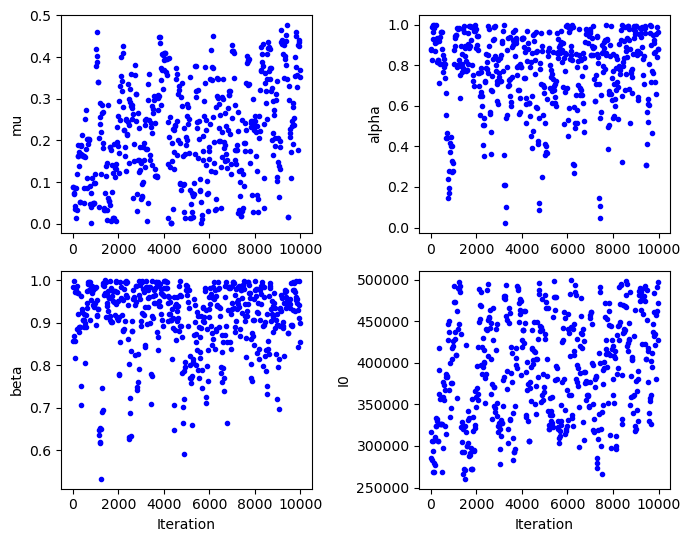

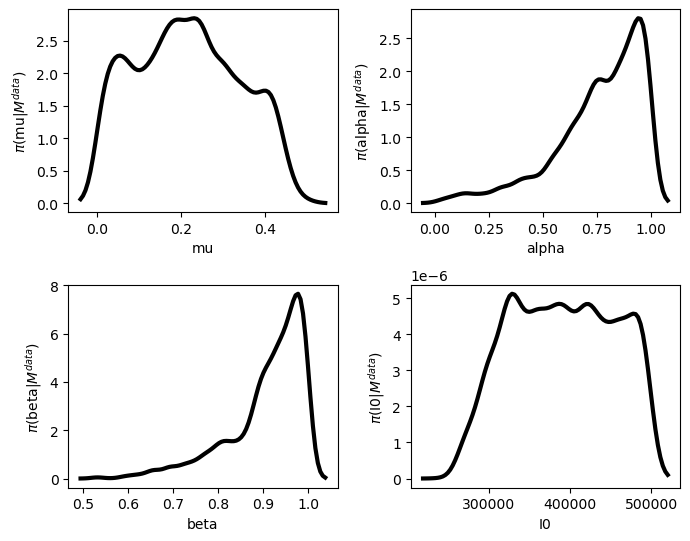

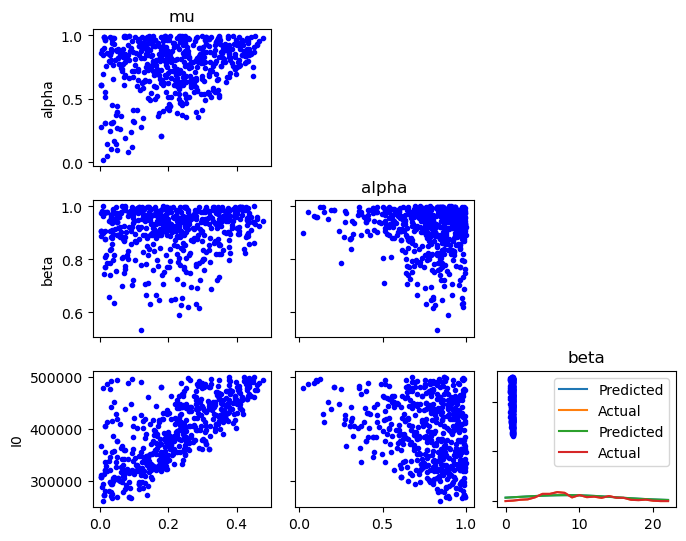

In [117]:
predictions = []
active = data.ACTIVE
phase = [1]
for i in range(len(phase)):

        
    df = data
    optimal_parameters = mh(df)

    predictions.extend(metrics_and_plot(df, optimal_parameters)[1])

#         intial_data = new_start_point
    print(metrics_and_plot(df, optimal_parameters))

In [125]:
r2_score(data['CONFIRMED'], predictions)

0.5067581661393598

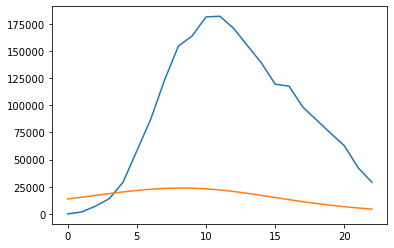

In [126]:
plt.plot(data['ACTIVE'])
plt.plot(predictions)

In [59]:
def whole_covid(data, population):
    N = population
    predictions = []
    active = data.ACTIVE
    phase = phases(active)
    intial_data = [N-1,1,0,0,0]
    for i in range(len(phase)):
        try:

            df = data[phase[i]:phase[i+1]]
            if i>1:
                I0 = df.ACTIVE.iloc[0]
                R0 = sum(data[:phase[i]].RECOVERED)
                D0 = df.DEATHS.iloc[0]
                E0 = df.CONFIRMED.iloc[0]
                S0 = N - (E0+I0+R0+D0)
                intial_data = S0, E0, I0, R0, D0
            optimal_parameters = mh(df, intial_data)
            new_start_point = metrics_and_plot(df, optimal_parameters,intial_data)[1]
            predictions.extend(metrics_and_plot(df, optimal_parameters, intial_data)[2])

    #         intial_data = new_start_point
            print(metrics_and_plot(df, optimal_parameters, intial_data))
            print(intial_data)

        except:
            df = data[phase[i]:]
            I0 = df.ACTIVE.iloc[0]
            R0 = sum(df.RECOVERED)
            D0 = df.DEATHS.iloc[0]
            E0 = df.CONFIRMED.iloc[0]
            S0 = 5000000 - (E0+I0+R0+D0)
            intial_data = S0, E0, I0, R0, D0
            optimal_parameters = mh(df, intial_data)
            new_start_point = metrics_and_plot(df, optimal_parameters,intial_data)[1]
            predictions.extend(metrics_and_plot(df, optimal_parameters, intial_data)[2])

    #         intial_data = new_start_point
            print(metrics_and_plot(df, optimal_parameters, intial_data))
            print(intial_data)
    return predictions


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
t_infective:      4.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
t_incubation:      5.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 R_0_start:      5.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
         k:      0.50 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
        x0:     50.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
   R_0_end:      0.50 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
         s:      0.05 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
       rho:      0.10 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1000 of 1000 complete in 1.6 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
t_infective:     15.48 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
t_incubation:      1.56 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 R_0_start:      2.24 [ 0.00e+00,    100.00] N

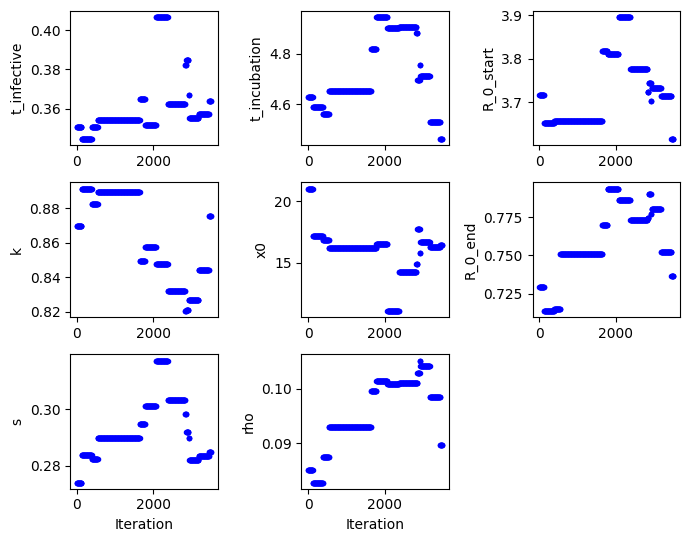

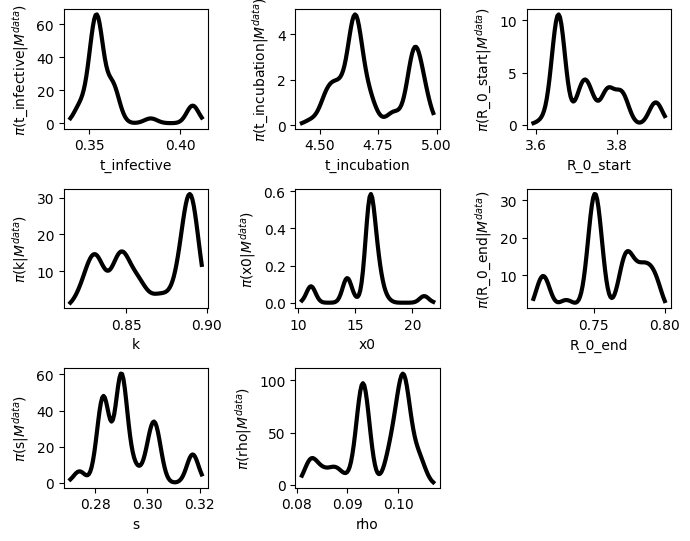

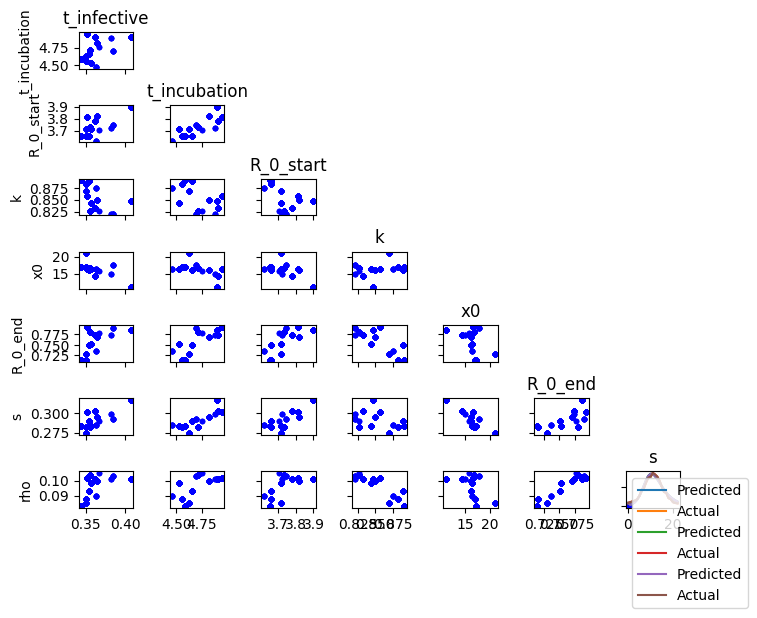

In [60]:
predictions= whole_covid(data, 539691)

In [61]:
r2_score(data['ACTIVE'], predictions)

0.9618024948729929

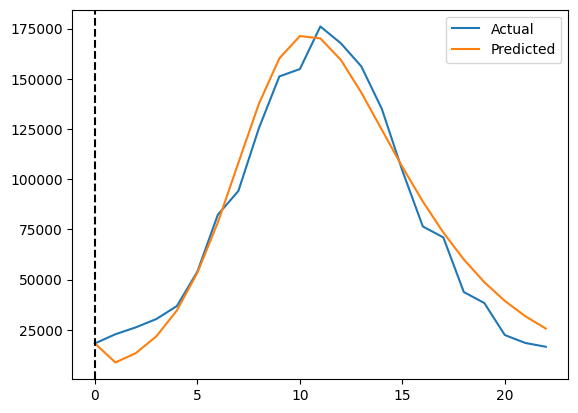

In [62]:
plt.plot(data['ACTIVE'], label = 'Actual')
plt.plot(predictions, label = 'Predicted')
for i in range(len(phases(active))):
    plt.axvline(x=phases(active)[i],color='k', linestyle='--')
plt.legend()

In [44]:
import numpy as np
def pend(y, t, b, c):
    theta, omega = y
    dydt = [theta,omega - c*np.sin(theta)]
    return dydt
b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 100, 101)

In [46]:
from scipy.integrate import odeint
sol = odeint(pend, y0, t, args=(b, c))

C:\Users\kapar\AppData\Local\Temp\ipykernel_5116\492322492.py:2: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(pend, y0, t, args=(b, c))


In [45]:
y1 = [0]*101
y2 = [0]*101

y1[0] = np.pi - 0.1
y2[0] = 

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]


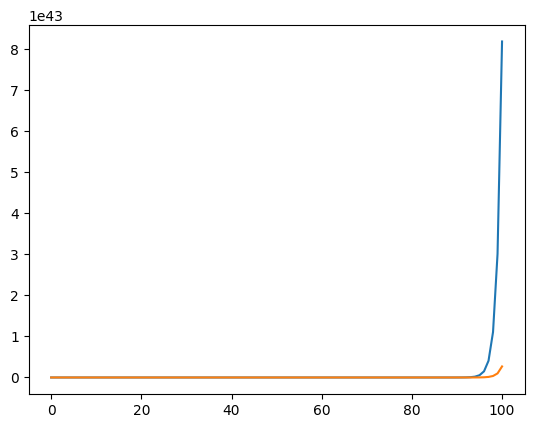

In [53]:
plt.plot(sol)

In [51]:
sol

array([[3.04159265e+00, 0.00000000e+00],
       [8.26790605e+00, 2.91413305e+00],
       [2.24744988e+01, 8.01513429e+00],
       [6.10920216e+01, 2.23248047e+01],
       [1.66065332e+02, 6.07025404e+01],
       [4.07732552e+02, 1.49116180e+02],
       [1.22706618e+03, 4.03428835e+01],
       [3.33551176e+03, 1.09663329e+02],
       [9.06686117e+03, 2.98095840e+02],
       [2.46462844e+04, 8.10308519e+02],
       [6.69955482e+04, 2.20264696e+03],
       [1.82112785e+05, 5.98741533e+03],
       [4.95033882e+05, 1.62754826e+04],
       [1.34564163e+06, 4.42413493e+04],
       [3.65783326e+06, 1.20260458e+05],
       [9.94302185e+06, 3.26901824e+05],
       [2.70279361e+07, 8.88611303e+05],
       [7.34695489e+07, 2.41549600e+06],
       [1.99710943e+08, 6.56599900e+06],
       [5.42870638e+08, 1.78482361e+07],
       [1.47567542e+09, 4.85165367e+07],
       [4.01130174e+09, 1.31881622e+08],
       [1.09038488e+10, 3.58491424e+08],
       [2.96397347e+10, 9.74480742e+08],
       [8.056915